In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [3]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]


In [4]:
train_path = r"C:\iit_mandi_projects\DL\Assignment1\datasets\adult\adult.data"

train_df = pd.read_csv(
    train_path,
    header=None,
    names=columns,
    sep=",",
    skipinitialspace=True
)
print(train_df['age'])

0        39
1        50
2        38
3        53
4        28
         ..
32556    27
32557    40
32558    58
32559    22
32560    52
Name: age, Length: 32561, dtype: int64


In [5]:
test_path = r"C:\iit_mandi_projects\DL\Assignment1\datasets\adult\adult.test"


test_df = pd.read_csv(
    test_path,
    header=None,
    names=columns,
    sep=",",
    skipinitialspace=True,
    skiprows=1
)
print(test_df['age'])

0        25
1        38
2        28
3        44
4        18
         ..
16276    39
16277    64
16278    38
16279    44
16280    35
Name: age, Length: 16281, dtype: int64


In [6]:
train_df["income"] = train_df["income"].str.strip()
test_df["income"] = test_df["income"].str.strip().str.replace(".", "", regex=False)
train_df = train_df.replace("?", np.nan).dropna()
test_df = test_df.replace("?", np.nan).dropna()
for df in [train_df, test_df]:
    df["income"] = (df["income"] == ">50K").astype(int)

In [7]:
train_df, val_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["income"]
)

y_train = train_df["income"].values
y_val = val_df["income"].values
y_test = test_df["income"].values

X_train_df = train_df.drop("income", axis=1)
X_val_df = val_df.drop("income", axis=1)
X_test_df = test_df.drop("income", axis=1)


X_train_df = pd.get_dummies(X_train_df)
X_val_df = pd.get_dummies(X_val_df)
X_test_df = pd.get_dummies(X_test_df)

X_train_df, X_val_df = X_train_df.align(X_val_df, join="left", axis=1, fill_value=0)
X_train_df, X_test_df = X_train_df.align(X_test_df, join="left", axis=1, fill_value=0)


X_train = X_train_df.values.T.astype(float)
X_val = X_val_df.values.T.astype(float)
X_test = X_test_df.values.T.astype(float)

y_train = y_train.reshape(1, -1).astype(float)
y_val = y_val.reshape(1, -1).astype(float)
y_test = y_test.reshape(1, -1).astype(float)

In [ ]:

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
w1 = neg / (pos + neg)
w0 = pos / (pos + neg)


def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))



In [10]:
def param_init(hidden1,hidden2,output_size):
    np.random.seed(42)

    input_size = X_train.shape[0]
    

    W1 = np.random.randn(hidden1, input_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((hidden1, 1))

    W2 = np.random.randn(hidden2, hidden1) * np.sqrt(2 / hidden1)
    b2 = np.zeros((hidden2, 1))

    W3 = np.random.randn(output_size, hidden2) * np.sqrt(2 / hidden2)
    b3 = np.zeros((output_size, 1))

    return W1,b1,W2,b2,W3,b3

    

    

In [11]:
def train(learning_rate,epochs,batch_size,W1,b1,W2,b2,W3,b3):
    num_samples = X_train.shape[1]
    it = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):

        for i in range(0, num_samples, batch_size):
            it += 1
            X_batch = X_train[:, i:i+batch_size]
            y_batch = y_train[:, i:i+batch_size]
            m = X_batch.shape[1]

            Z1 = np.dot(W1, X_batch) + b1
            A1 = relu(Z1)

            Z2 = np.dot(W2, A1) + b2
            A2 = relu(Z2)

            Z3 = np.dot(W3, A2) + b3
            y_hat = sigmoid(Z3)

            loss = -np.mean(
                w1*y_batch * np.log(y_hat + 1e-8) +
                w0*(1 - y_batch) * np.log(1 - y_hat + 1e-8)
            )
            dZ3 = (w1 * y_batch + w0 * (1 - y_batch)) * (y_hat - y_batch)

            dW3 = np.dot(dZ3, A2.T) / m
            db3 = np.sum(dZ3, axis=1, keepdims=True) / m

            dA2 = np.dot(W3.T, dZ3)
            dZ2 = dA2 * relu_derivative(Z2)
            dW2 = np.dot(dZ2, A1.T) / m
            db2 = np.sum(dZ2, axis=1, keepdims=True) / m

            dA1 = np.dot(W2.T, dZ2)
            dZ1 = dA1 * relu_derivative(Z1)
            dW1 = np.dot(dZ1, X_batch.T) / m
            db1 = np.sum(dZ1, axis=1, keepdims=True) / m

            W3 -= learning_rate * dW3
            b3 -= learning_rate * db3

            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2

            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1

            if it % 100 == 0:
            

                Z1v = W1 @ X_val + b1
                A1v = relu(Z1v)
                Z2v = W2 @ A1v + b2
                A2v = relu(Z2v)
                Z3v = W3 @ A2v + b3
                y_val_hat = sigmoid(Z3v)

                val_loss = -np.mean(
                    w1 * y_val * np.log(y_val_hat + 1e-8) +
                    w0 * (1 - y_val) * np.log(1 - y_val_hat + 1e-8)
                )

                train_losses.append(loss)
                val_losses.append(val_loss)

                
                print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")


    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()

    

In [24]:
def test(W1,b1,W2,b2,W3,b3):
    Z1 = W1 @ X_test + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)
    Z3 = W3 @ A2 + b3
    y_pred = sigmoid(Z3)

    y_pred_labels = (y_pred > 0.5).astype(int)
    accuracy = np.mean(y_pred_labels == y_test)
    return accuracy

Epoch 1/30 | Train Loss: 0.2269 | Val Loss: 0.2592
Epoch 1/30 | Train Loss: 0.2704 | Val Loss: 0.2592
Epoch 1/30 | Train Loss: 0.2432 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2976 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2650 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2813 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2487 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2596 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2324 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 5/30 | Train Loss: 0.2596 | Val Loss: 0.2592
Epoch 5/30 | Train Loss: 0.2323 | Val Loss: 0.2592
Epoch 5/30 | Train Loss: 0.2813 | Val Loss: 0.2592
Epoch 6/30 | Train Loss: 0.2704 | Val Loss: 0.2592
Epoch 6/30 | Train Loss: 0.2596

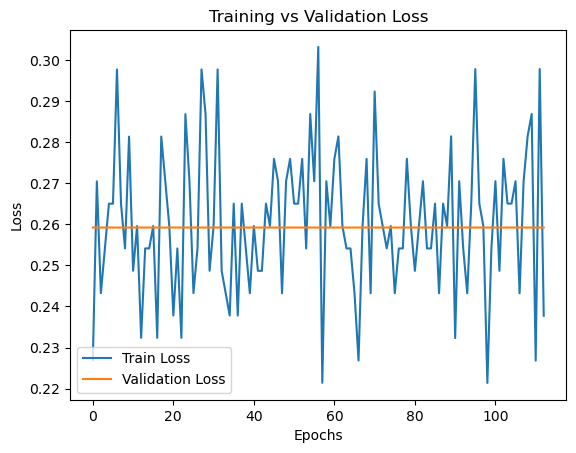

In [27]:
W1,b1,W2,b2,W3,b3 = param_init(64,32,1)
train(0.001,30,64,W1,b1,W2,b2,W3,b3)

In [28]:
accuracy = test(W1,b1,W2,b2,W3,b3)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7543160690571049


Latent Space Analysis

In [33]:
def prepare_for_pca(A, Z, name=""):
    """
    Use ReLU activations if they have variance,
    otherwise fall back to pre-activation values.
    """
    A_T = A.T
    var = np.var(A_T, axis=0)
    active = var > 1e-6

    if np.sum(active) == 0:
        print(f"[INFO] {name}: All ReLU neurons inactive. Using pre-activation Z.")
        return Z.T
    else:
        return A_T[:, active]


In [34]:
# Forward pass on test data
Z1_test = np.dot(W1, X_test) + b1
A1_test = relu(Z1_test)

Z2_test = np.dot(W2, A1_test) + b2
A2_test = relu(Z2_test)


In [35]:
A1_pca_input = prepare_for_pca(A1_test, Z1_test, "Hidden Layer 1")
A2_pca_input = prepare_for_pca(A2_test, Z2_test, "Hidden Layer 2")


[INFO] Hidden Layer 1: All ReLU neurons inactive. Using pre-activation Z.
[INFO] Hidden Layer 2: All ReLU neurons inactive. Using pre-activation Z.


In [36]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
A1_2D = pca1.fit_transform(A1_pca_input)

pca2 = PCA(n_components=2)
A2_2D = pca2.fit_transform(A2_pca_input)


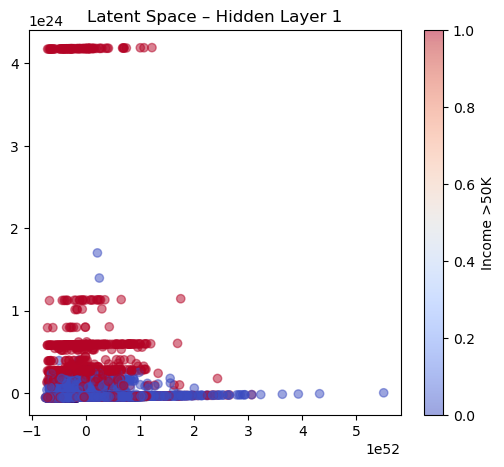

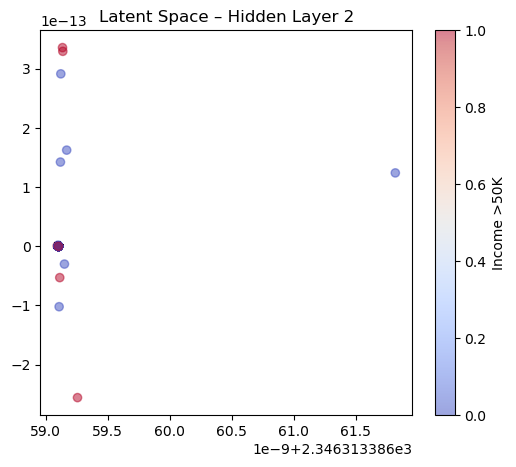

In [37]:
plt.figure(figsize=(6,5))
plt.scatter(A1_2D[:,0], A1_2D[:,1],
            c=y_test.flatten(),
            cmap="coolwarm",
            alpha=0.5)
plt.title("Latent Space – Hidden Layer 1")
plt.colorbar(label="Income >50K")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(A2_2D[:,0], A2_2D[:,1],
            c=y_test.flatten(),
            cmap="coolwarm",
            alpha=0.5)
plt.title("Latent Space – Hidden Layer 2")
plt.colorbar(label="Income >50K")
plt.show()


Hyperparameter tuning


Epoch 1/30 | Train Loss: 0.2269 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2704 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2432 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2460 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2977 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2650 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2813 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2487 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2596 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2323 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2514 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2323 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2814 | Val Loss: 0.2584
Epoch 6/30 | Train Loss: 0.2705 | Val Loss: 0.2584
Epoch 6/30 | Train Loss: 0.2596

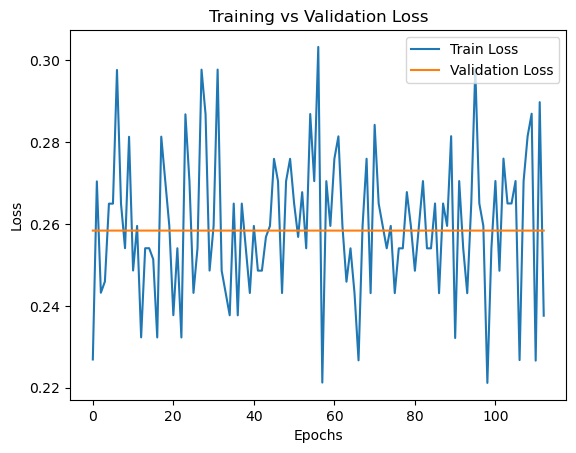

In [14]:
W1,b1,W2,b2,W3,b3 = param_init(32, 16, 1)

train(0.001,30,64,W1,b1,W2,b2,W3,b3)

In [22]:
accuracy = test(W1,b1,W2,b2,W3,b3)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7565737051792829
Test Accuracy: None


Epoch 1/30 | Train Loss: 0.2269 | Val Loss: 0.2592
Epoch 1/30 | Train Loss: 0.2704 | Val Loss: 0.2592
Epoch 1/30 | Train Loss: 0.2432 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2592
Epoch 2/30 | Train Loss: 0.2976 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2650 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2813 | Val Loss: 0.2592
Epoch 3/30 | Train Loss: 0.2487 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2596 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2324 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2592
Epoch 5/30 | Train Loss: 0.2596 | Val Loss: 0.2592
Epoch 5/30 | Train Loss: 0.2324 | Val Loss: 0.2592
Epoch 5/30 | Train Loss: 0.2813 | Val Loss: 0.2592
Epoch 6/30 | Train Loss: 0.2704 | Val Loss: 0.2592
Epoch 6/30 | Train Loss: 0.2596

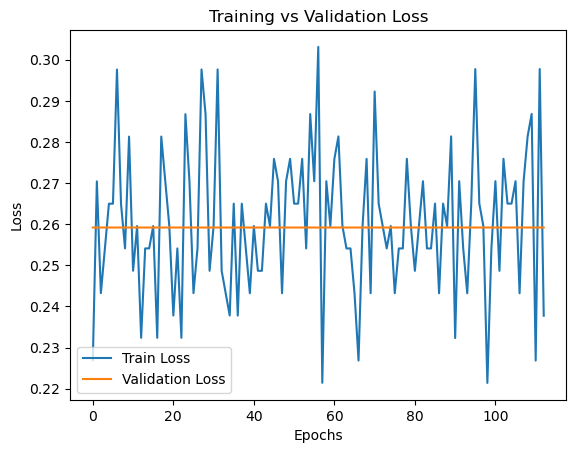

In [16]:

W1,b1,W2,b2,W3,b3 = param_init(128, 64, 1)

train(0.001,30,64,W1,b1,W2,b2,W3,b3)


In [ ]:
accuracy = test(W1,b1,W2,b2,W3,b3)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7543160690571049


Epoch 1/30 | Train Loss: 0.2271 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2704 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2432 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2460 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2650 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2978 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2650 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2815 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2486 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2596 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2322 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2514 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2321 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2816 | Val Loss: 0.2584
Epoch 6/30 | Train Loss: 0.2705 | Val Loss: 0.2584
Epoch 6/30 | Train Loss: 0.2596

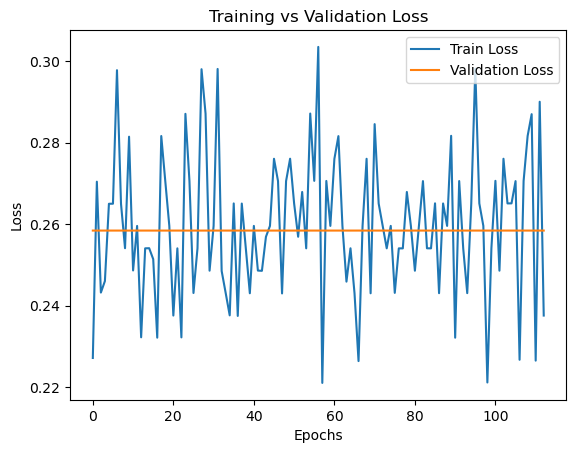

Test Accuracy: 0.7565737051792829
Epoch 1/30 | Train Loss: 0.2265 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2706 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2430 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2459 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2651 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2651 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2982 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2651 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2540 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2816 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2485 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2596 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2320 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2540 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2514 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2320 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2816 | Val Loss: 0.2584
Epoch 6/30 | Train Loss: 0.2706 | Val Loss: 0.25

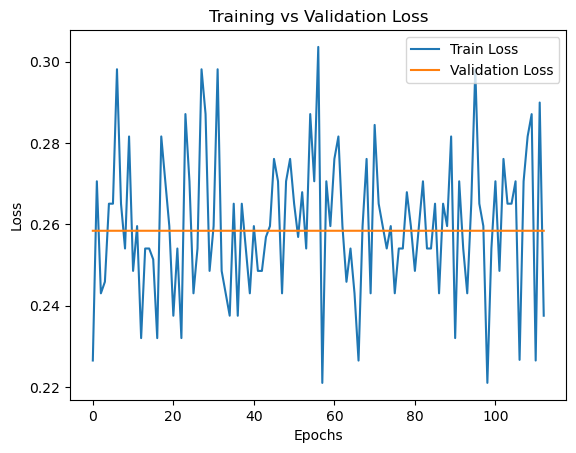

Test Accuracy: 0.7565737051792829
Epoch 1/30 | Train Loss: 0.2265 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2706 | Val Loss: 0.2584
Epoch 1/30 | Train Loss: 0.2430 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2459 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2651 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2651 | Val Loss: 0.2584
Epoch 2/30 | Train Loss: 0.2982 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2651 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2540 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2816 | Val Loss: 0.2584
Epoch 3/30 | Train Loss: 0.2485 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2596 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2320 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2540 | Val Loss: 0.2584
Epoch 4/30 | Train Loss: 0.2541 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2514 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2320 | Val Loss: 0.2584
Epoch 5/30 | Train Loss: 0.2816 | Val Loss: 0.2584
Epoch 6/30 | Train Loss: 0.2706 | Val Loss: 0.25

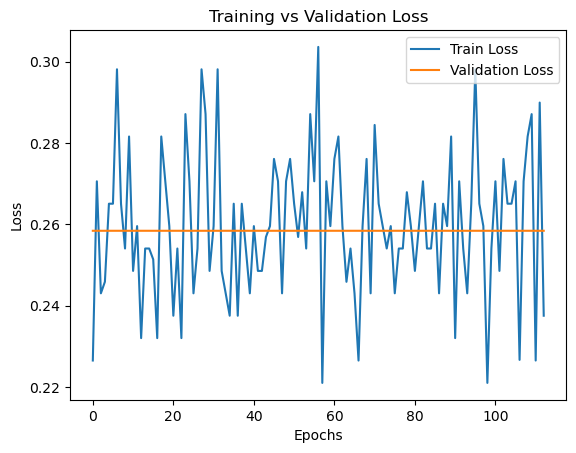

Test Accuracy: 0.7565737051792829


In [26]:
W1,b1,W2,b2,W3,b3 = param_init(64,32,1)
train(0.01, 30, 64, W1,b1,W2,b2,W3,b3)
accuracy = test(W1,b1,W2,b2,W3,b3)
print("Test Accuracy:", accuracy)

train(0.001, 30, 64, W1,b1,W2,b2,W3,b3)
accuracy = test(W1,b1,W2,b2,W3,b3)
print("Test Accuracy:", accuracy)

train(0.0005, 30, 64,W1,b1,W2,b2,W3,b3)
accuracy = test(W1,b1,W2,b2,W3,b3)
print("Test Accuracy:", accuracy)
